# Training and Running of new GLM model
This Notebook is for training and running the our new GLM model that includes (for now only) deletion tokens

## Adding necessary imports
You can run this block to import necessary classes and functions

In [5]:
from fundemental_classes.model_related.glm_model import GLMModel

# You can change force_retrain to True if you want to always retrain your model everytime
model = GLMModel("./dna_bert_final", "simulated_sequences/augumented_sequence_size10000_length150_deletions0.2_nodeletionseq0.1.fasta", force_retrain=False)

Initializing fresh model
No trained model loaded. Call train() to train the model.


## Training
We use `Bert` model to create the embeddings and train it using masking to get nicely trained model. If you want to change the size of training data, please look into `simulated_sequences` directory. \\\
*important:* Training is not necessary if you already have a trained model. You can load it using the `GLMModel`.

Dataset split: 4000 training, 1000 validation
Starting Training


***** Running training *****
  Num examples = 4,000
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15,000
  Number of trainable parameters = 8,620,042


Step,Training Loss,Validation Loss
500,1.482600,1.467343
1000,1.465600,1.469456
1500,1.438500,1.424855
2000,1.419000,1.405494
2500,1.396600,1.391022
3000,1.363200,1.362870
3500,1.341100,1.332424
4000,1.318300,1.283082
4500,1.294600,1.264443
5000,1.248700,1.244549



***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./dna_bert_final/checkpoint-500
Configuration saved in ./dna_bert_final/checkpoint-500/config.json
Model weights saved in ./dna_bert_final/checkpoint-500/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./dna_bert_final/checkpoint-500/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./dna_bert_final/checkpoint-1000
Configuration saved in ./dna_bert_final/checkpoint-1000/config.json
Model weights saved in ./dna_bert_final/checkpoint-1000/model.safetensors
Saving Trainer.data_collator.tokenizer by default as Trainer.processing_class is `None`
tokenizer config file saved in ./dna_bert_final/checkpoint-1000/tokenizer_config.json
Special tokens file saved

Saving model and tokenizer...
Training complete
Metadata saved to ./dna_bert_final/training_metadata.json
Training curves saved to ./dna_bert_final/training_curves.png


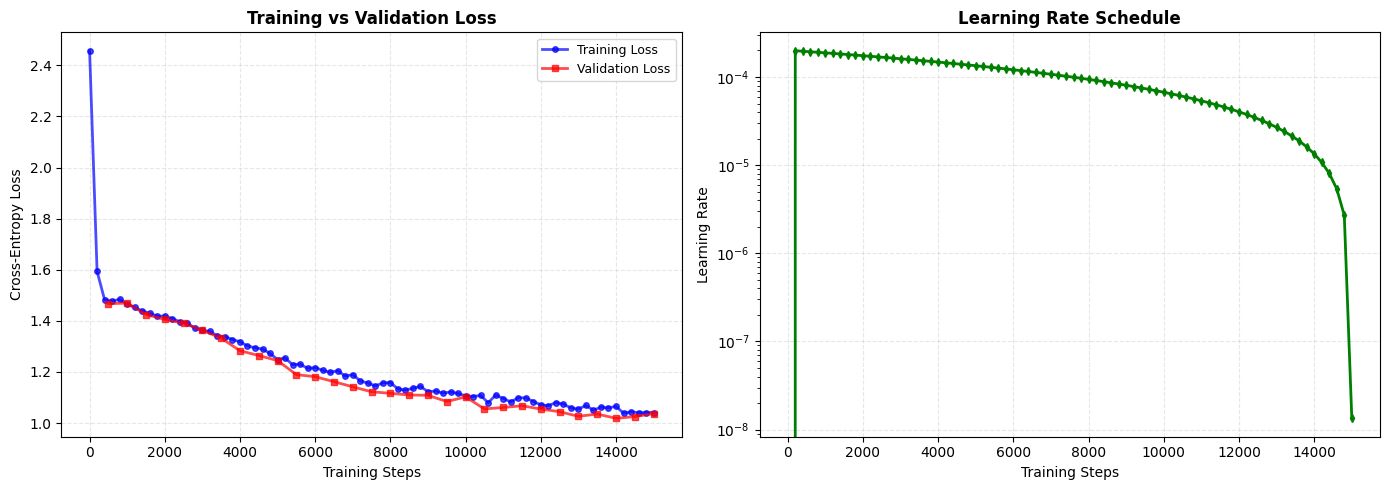


Training Summary:
Final training loss: 1.0413
Final validation loss: 1.0371
Best validation loss: 1.0185
Training history saved to ./dna_bert_final/training_history.json


In [2]:
model.train(epochs=30, batch_size=8, lr=2e-4)

## Visualization | Sequence reconstruction probabilities
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\
*Important:* For now we pass our test cases by hand. However in the future we will generate good inputs to test how well the model functions

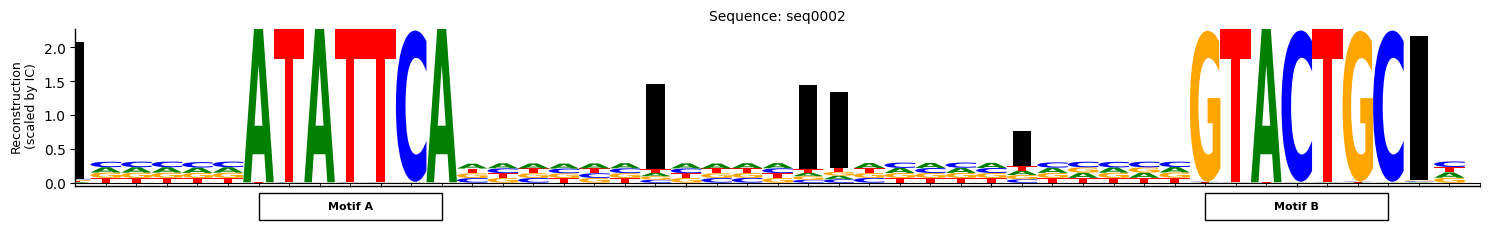

In [32]:
from fundemental_classes.visualization.sequence_plotter import plot

header = "seq0002|label=both|posAmotif=6|posBmotif=37|gaplength=20|deletions=6"
sequence = "-TTTCTATATTCAGCTATA-CGCC--TGTTA-TCCTGGTACTGC-G"
prob_matrix = model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6)

/Users/wenjia/Documents/Sysgen-GLM-for-Indels/fundemental_classes/visualization/sequence_plotter_new.py:91: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


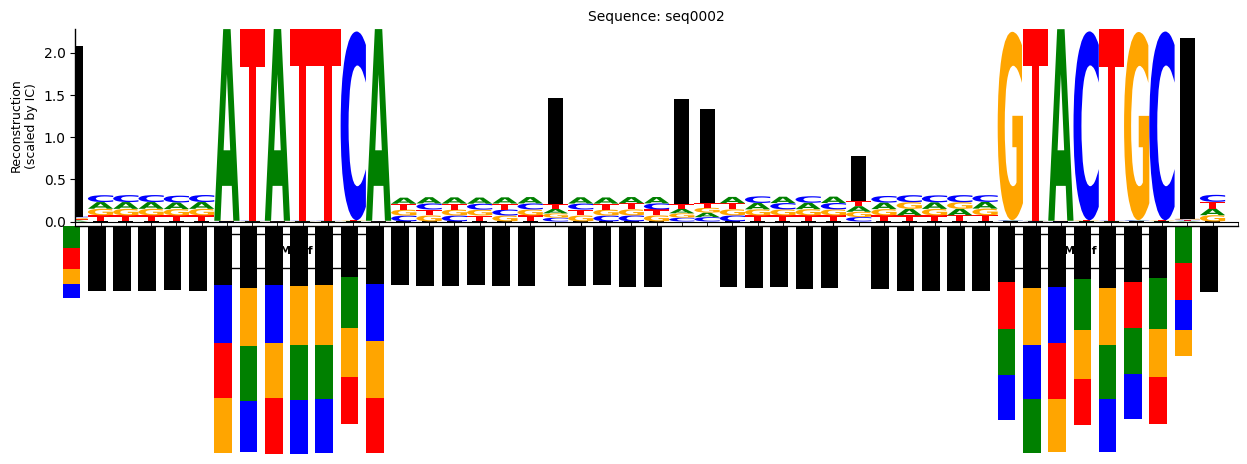

In [18]:
from fundemental_classes.visualization.sequence_plotter_new import plot

header = "seq0002|label=both|posAmotif=6|posBmotif=37|gaplength=20|deletions=6"
sequence = "-TTTCTATATTCAGCTATA-CGCC--TGTTA-TCCTGGTACTGC-G"
prob_matrix = model.get_full_reconstruction_probs(sequence)

plot(header, sequence, prob_matrix, motif_length=6)

## Visualization | Dependency Map
This block is used for getting already trained model, passing the sequence to test how well the model performs.
\\\\\

Computing dependency map...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 121/121 [00:00<00:00, 14127.35 examples/s]


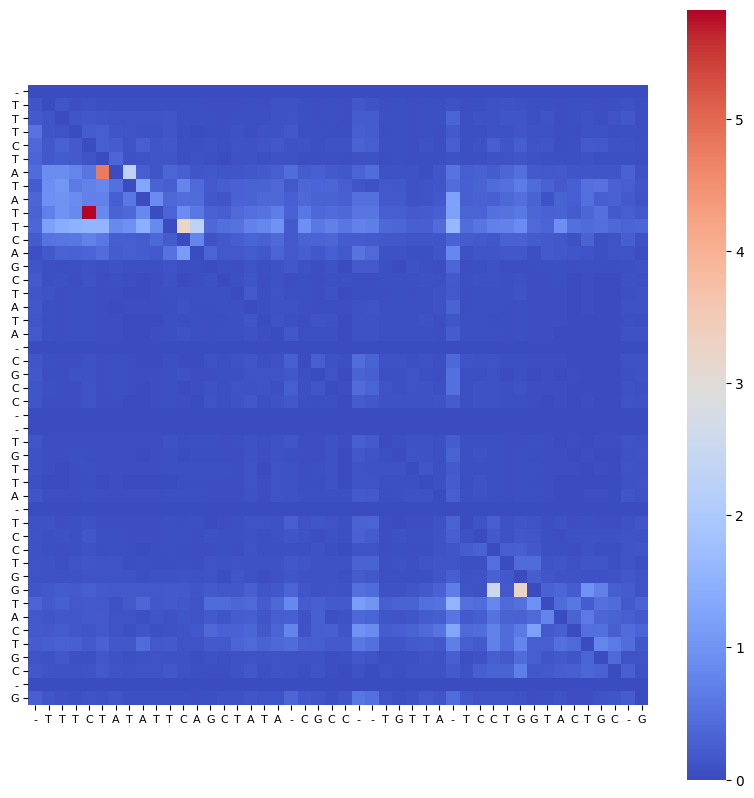

In [2]:
# just the heatmap
from fundemental_classes.visualization.heat_map_plotter import DependencyMapGenerator

header = "seq0002|label=both|posAmotif=6|posBmotif=37|gaplength=20|deletions=6"
sequence = "-TTTCTATATTCAGCTATA-CGCC--TGTTA-TCCTGGTACTGC-G"

dep_gen = DependencyMapGenerator(model, type='snp')
prob_matrix = model.get_full_reconstruction_probs(sequence)
dep_map = dep_gen.analyze(sequence, show_plot=True)

In [ ]:

from fundemental_classes.visualization.heat_map_plotter import DependencyMapGenerator
import numpy as np
import plotly.graph_objects as go
from fundemental_classes.visualization.sequence_logo import SequenceLogo

# a function for creating the heatmap with overlayed logo with input sequence, type of dependency and model
def depencency_map_with_logo(model, sequence, type='snp'):

    dep_gen = DependencyMapGenerator(model, type=type)
    prob_matrix = model.get_full_reconstruction_probs(sequence)
    dep_map = dep_gen.analyze(sequence, show_plot=False)
    L = dep_map.shape[0]
    reconstruction_logo = SequenceLogo.from_reconstruction(prob_matrix) 
    fig = go.Figure()
    fig.add_trace(
        go.Heatmap(
            z=dep_map,
            x=np.arange(L),
            y=np.arange(L),
            colorscale="RdBu_r",
        )
    )
    # if the xaxes and yaxes are shown
    fig.update_xaxes(visible=True, scaleanchor="y", constrain="domain")
    fig.update_yaxes(visible=True, autorange="reversed", scaleanchor="x", constrain="domain")
    # Overlay logo at the top 
    fig.add_layout_image(
        source=reconstruction_logo.to_svg(data_url=True), 
        xref="x",
        yref="y domain",
        x=-0.5,          # align left edge of first column
        y=1.0,           # top of heatmap domain
        sizex=L,         # span exactly L columns
        sizey=0.10,      # height in domain units (tune)
        xanchor="left",
        yanchor="bottom",
        sizing="stretch",
    )
    fig.update_layout(
        width=900,
        height=900,
        margin=dict(l=20, r=20, t=100, b=20),
    )
    fig.show()


In [11]:

header = "seq0002|label=both|posAmotif=6|posBmotif=37|gaplength=20|deletions=6"
sequence = "-TTTCTATATTCAGCTATA-CGCC--TGTTA-TCCTGGTACTGC-G"
dep_map = depencency_map_with_logo(model, sequence, type='indel')

Computing dependency map...


Map: 100%|██████████| 41/41 [00:00<00:00, 13069.35 examples/s]
